# FUSE Introductory Tutorial

Download this tutorial from the [FuseExamples repository](https://github.com/ProjectTorreyPines/FuseExamples/blob/master/tutorial.ipynb)

## Basic concepts

To make sense of this tutorial, you'll need to know the following organization concepts of FUSE:

1. **📂 Data storage**: All data is stored in the `dd` structure, which follows the ITER IMAS ontology.
2. **🧠 Actors**: The core components of FUSE simulations are physics and engineering actors.
3. **🕹️ Control**: Actor functionality is governed by `act` parameters.
4. **🚀 Initialization**: The data structure can be initialized from 0D `ini` parameters.
5. **🔧 Use cases**: FUSE includes templates for various machines (e.g., FPP, ITER, ARC).
6. **🔄 Workflows**: Self-contained studies and optimizations are conducted via workflows, typically involving multiple FUSE simulations.
7. **🌍 Interoperability**: FUSE interfaces with existing modeling tools like OMFIT/OMAS and the IMAS ecosystem.

A diagram illustrating these concepts is provided below:  
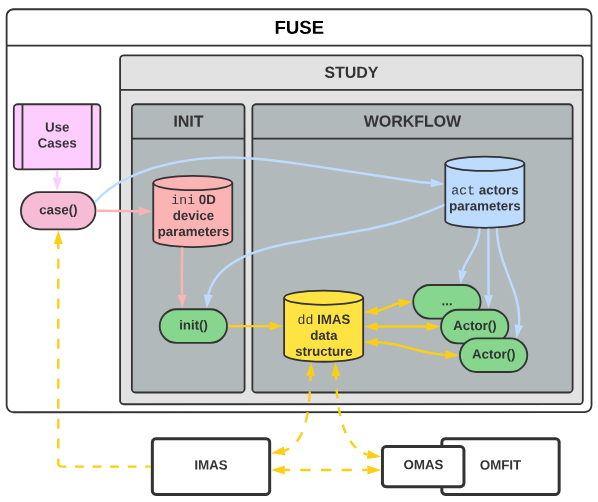

# Let's get started!
-----------

**NOTE**: Julia is a Just In Time (JIT) programming language. The first time something is executed it will take longer because of the compilation process. Subsequent calls the the same code will be blazingly fast.

-----------

Import the necessary packages

In [ ]:
using Plots # for plotting
using FUSE # this will also import IMAS in the current namespace

## Starting from a use-case

FUSE comes with some predefined [use-cases](https://fuse.help/stable/cases.html), some of which are used for regression testing.

Note that some use cases are for non-nuclear experiments and certain Actors like Blankets or BalanceOfPlant will not perform any actions.

In [ ]:
FUSE.test_cases

Get initial parameters (`ini`) and actions (`act`) for a given use-case

In [ ]:
ini, act = FUSE.case_parameters(:KDEMO);

Modifying [`ini` parameters](https://fuse.help/stable/ini.html).

In [ ]:
ini.equilibrium.B0 = 7.8
ini.equilibrium.R0 = 6.5;

Modifying [`act` parameters](https://fuse.help/stable/act.html).

In [ ]:
act.ActorCoreTransport.model = :FluxMatcher;

Initialize the data dictionary (`dd`) using the 0D parameters.

**NOTE:** `init()` does not return a self-consistent solution, just a plausible starting point to initialize our simulations!

In [ ]:
dd = IMAS.dd() # an empty dd
FUSE.init(dd, ini, act);

We can `@checkin` and `@checkout` variables with an associated tag.

This is handy to save and restore our progress (we'll use this later).

In [ ]:
@checkin :init dd ini act

## Exploring the data dictionary
* FUSE stores data following the IMAS data schema.
* The root of the data structure is `dd`, which stands for "Data Dictionary".
* More details are available in the [documentation](https://fuse.help/stable/dd.html).

Display part of the equilibrium data in `dd`

In [ ]:
dd.equilibrium.time_slice[1].boundary

this can be done up to a certain depth with `print_tree`

In [ ]:
print_tree(dd.equilibrium.time_slice[1].boundary; maxdepth=1)

## Plotting data from `dd`
FUSE uses `Plots.jl` recipes for visualizing data from `dd`.

This allows different plots to be shown when calling `plot()` on different items in the data structure.

Learn more about Plots.jl [here](https://docs.juliaplots.org)

For example plotting the equilibrium...

In [ ]:
plot(dd.equilibrium)

...or the core profiles

In [ ]:
plot(dd.core_profiles)

Whant to know what arguments can be passed? use `help_plot()` function

In [ ]:
help_plot(dd.equilibrium; core_profiles_overlay=true, psi_levels_in=21, psi_levels_out=5, show_secondary_separatrix=true, coordinate=:psi_norm)

These plots can be composed by calling `plot!()` instead of `plot()`

In [ ]:
plot(dd.equilibrium; color=:gray, cx=true)
plot!(dd.build.layer)
plot!(dd.pf_active)
plot!(dd.pf_passive)
plot!(dd.pulse_schedule.position_control; color=:red)

Plotting an array...

In [ ]:
plot(dd.core_profiles.profiles_1d[1].pressure_thermal)

...is different from plotting a field from the IDS (which plots the quantity against its coordinate and with units)

In [ ]:
plot(dd.core_profiles.profiles_1d[1], :pressure_thermal)

Customizing plot attributes:

In [ ]:
plot(dd.core_profiles.profiles_1d[1], :pressure_thermal; label="", linewidth=2, color=:red, labelfontsize=25)

Use `findall(ids, r"...")` to search for certain fields. In Julia, string starting with `r` are regular expressions.

In [ ]:
findall(dd, r"\.psi")

`findall(ids, r"...")` can be combined with `plot()` to plot multiple fields

In [ ]:
plot(findall(dd, r"\.psi"))

## Working with time series

The IMAS data structure supports time-dependent data, and IMAS.jl provides ways to handle time data efficiently.

Each `dd` has a `global_time` attribute, which is used throughout FUSE and IMAS to indicate the time at which things should be operate.

In [ ]:
dd.global_time

For the sake of demonstrating handling of time, let's add a new time_slice to the equilibrium.

NOTE: time dependent arrays of structures can be resized with `resize!(ids, time0::Float64)` in addition to the usual `resize!(ids, n::Int)`.

In [ ]:
# resize the time dependent array of structure
resize!(dd.equilibrium.time_slice, 1.0);

# let's just populate it with the data from the previous time slice
dd.equilibrium.time_slice[2] = deepcopy(dd.equilibrium.time_slice[1]);
dd.equilibrium.time_slice[2].time = 1.0

Here we see that equilibrium has mulitiple time_slices

In [ ]:
dd.equilibrium.time

We can access time-dependent arrays of structures via integer index...

In [ ]:
eqt = dd.equilibrium.time_slice[2]
eqt.time

...or at a given time, by passing the time as a floating point number (in seconds)

In [ ]:
eqt = dd.equilibrium.time_slice[1.0]
eqt.time

NOTE: If we ask a time that is not exactly in the arrays of structures, we'll get the closest (causal!) time-slice

In [ ]:
eqt = dd.equilibrium.time_slice[0.9]
eqt.time

In [ ]:
eqt = dd.equilibrium.time_slice[1.1]
eqt.time

... or at the current `dd.global_time` by leaving the square brackets empty []

NOTE: __This is what you want to use in most situations that involve arrays of structures!__

In [ ]:
dd.global_time = 0.0
eqt = dd.equilibrium.time_slice[]
eqt.time

In [ ]:
dd.global_time = 1.0
eqt = dd.equilibrium.time_slice[]
eqt.time

What we described above was for time-dependent arrays of structures.

The other place where time comes in, is when dealing with time-dependent arrays of data.

In this case, we can use the `@ddtime` macro to manipulate these time-dependent arrays at `dd.global_time`.

NOTE: Also in this case, `@ddtime` will operate on the closest (causal!) time point

In [ ]:
dd.equilibrium.vacuum_toroidal_field.b0

In [ ]:
dd.global_time = 1.0
@ddtime(dd.equilibrium.vacuum_toroidal_field.b0 = 10.0)
dd.equilibrium.vacuum_toroidal_field.b0

In [ ]:
dd.global_time = 0.0
@ddtime(dd.equilibrium.vacuum_toroidal_field.b0)

In [ ]:
dd.global_time = 1.0
@ddtime(dd.equilibrium.vacuum_toroidal_field.b0)

## Expressions in `dd`

Some fields in the data dictionary are expressions (ie. Functions).
For example `dd.core_profiles.profiles_1d[].pressure` is dynamically calculated as the product of thermal densities and temperature with addition of fast ions contributions

In [ ]:
dd.global_time = 0.0
print_tree(dd.core_profiles.profiles_1d[]; maxdepth=1)

accessing a dynamic expression, automatically evaluates it

In [ ]:
dd.core_profiles.profiles_1d[].conductivity_parallel

In addition to evaluating expressions by accessing them, expressions in the tree can be evaluated using `IMAS.freeze(ids)`

NOTE: `IMAS.freeze(ids, field::Symbol)` works on a single field and `IMAS.refreeze!(ids, field)` forces re-evaluation of an expression. Also, `IMAS.empty!(ids, field::Symbol)` can be used to revert a frozen field back into an expression.

In [ ]:
print_tree(IMAS.freeze(dd.core_profiles.profiles_1d[1]); maxdepth=1)

## Whole facility design

Here we restore the `:init` checkpoint that we had previously stored. Resetting any changes to `dd`, `ini`, and `act` that we did in the meantime.

In [ ]:
@checkout :init dd ini act

Actors in FUSE can be executed by passing two arguments to them: `dd` and `act`.
Internally, actors can call other actors, creating workflows.
For example, the `ActorWholeFacility` can be used to to get a self-consistent stationary whole facility design.
The `actors:` print statements with their nested output tell us what actors are calling other actors.

In [ ]:
FUSE.ActorWholeFacility(dd, act);

Let's check what we got at a glance with the `FUSE.digest(dd)` function:

In [ ]:
FUSE.digest(dd)

Like before we can checkpoint results for later use

In [ ]:
@checkin :awf dd ini act

## Running a custom workflow

Let's now run a series of actors similar to what `ActorWholeFacility` does
and play around with plotting to get a sense of what each individual actor does.

Let's start again from after the initialization stage

In [ ]:
@checkout :init dd ini act

Let's start by positioning the PF coils, so that we stand a chance to reproduce the desired plasma shape.
This will be important to ensure the stability of the `ActorStationaryPlasma` that we are going to run next.

In [ ]:
FUSE.ActorPFdesign(dd, act; do_plot=true); # instead of setting `act.ActorPFdesign.do_plot=true` we can just pass `do_plot=true` as argument without chaning `act`

The `ActorStationaryPlasma` iterates between plasma transport, pedestal, equilibrium and sources to return a self-consistent plasma solution

In [ ]:
peq = plot(dd.equilibrium; label="before")
pcp = plot(dd.core_profiles; color=:gray, label="before")
FUSE.ActorStationaryPlasma(dd, act);

we can compare equilibrium before and after the self-consistency loop

In [ ]:
plot!(peq, dd.equilibrium; label="after")

we can compare core_profiles before and after the self-consistency loop

In [ ]:
plot!(pcp, dd.core_profiles; label="after")

here are the sources

In [ ]:
plot(dd.core_sources)

and the flux-matched transport

In [ ]:
plot(dd.core_transport)

HFS sizing actor changes the thickness of the OH and TF layers on the high field side to satisfy current and stresses constraints

In [ ]:
plot(dd.build)
FUSE.ActorHFSsizing(dd, act);
plot!(dd.build; cx=false)

The stresses on the center stack are stored in the `solid_mechanics` IDS

In [ ]:
plot(dd.solid_mechanics.center_stack.stress)

LFS sizing actors change location of the outer TF leg to meet ripple requirements

In [ ]:
plot(dd.build)
FUSE.ActorLFSsizing(dd, act);
plot!(dd.build; cx=false)

A custom `show()` method is defined to print the summary of `dd.build.layer`

In [ ]:
dd.build.layer

ActorHFSsizing and ActorLFSsizing only change the layer's thicknesses, so we then need to trigger a build of the 2D cross-sections after them:

In [ ]:
FUSE.ActorCXbuild(dd, act);
plot(dd.build)

Generate passive structures information (for now the vacuum vessel)

In [ ]:
FUSE.ActorPassiveStructures(dd, act)
plot(dd.pf_passive)

We can now give the PF coils their final position given the new build

In [ ]:
actor = FUSE.ActorPFdesign(dd, act);
plot(actor) # some actors define their own plot

With information about both pf_active and pf_passive we can now evaluate vertical stability

In [ ]:
FUSE.ActorVerticalStability(dd, act)
IMAS.freeze(dd.mhd_linear)

The `ActorNeutronics` calculates the heat flux on the first wall

In [ ]:
FUSE.ActorNeutronics(dd, act);
p = plot(; layout=2, size=(900, 350))
plot!(p, dd.neutronics.time_slice[].wall_loading, subplot=1)
plot!(p, FUSE.define_neutrons(dd, 100000)[1], dd.equilibrium.time_slice[]; subplot=1, colorbar_entry=false)
plot!(p, dd.neutronics.time_slice[].wall_loading; cx=false, subplot=2, ylabel="")

The `ActorBlanket` will change the thickess of the first wall, breeder, shield, and Li6 enrichment to achieve target TBR

In [ ]:
FUSE.ActorBlanket(dd, act);
print_tree(IMAS.freeze(dd.blanket); maxdepth=5)

The `ActorDivertors` actor calculates the divertors heat flux

In [ ]:
FUSE.ActorDivertors(dd, act);
print_tree(IMAS.freeze(dd.divertors); maxdepth=4)

The `ActorBalanceOfPlant` calculates the optimal cooling flow rates for the heat sources (breeder, divertor, and wall) and get an efficiency for the electricity conversion cycle

In [ ]:
FUSE.ActorBalanceOfPlant(dd, act);
IMAS.freeze(dd.balance_of_plant)

`ActorCosting` will break down the capital and operational costs

In [ ]:
FUSE.ActorCosting(dd, act)
plot(dd.costing)

Let's checkpoint our results

In [ ]:
@checkin :manual dd ini act

## Saving and loading data

In [ ]:
tutorial_temp_dir = tempdir()
filename = joinpath(tutorial_temp_dir, "$(ini.general.casename).json")

When saving data to be shared outside of FUSE, one can set `freeze=true` so that all expressions in the dd are evaluated and saved to file.

In [ ]:
IMAS.imas2json(dd, filename; freeze=false, strict=false);

Load from JSON

In [ ]:
dd1 = IMAS.json2imas(filename);

## Comparing two IDSs
We can introduce a change in the `dd1` and spot it with the `diff` function

In [ ]:
dd1.equilibrium.time_slice[1].time = -100.0
IMAS.diff(dd.equilibrium, dd1.equilibrium)

## Summary
Snapshot of `dd` in 0D quantities (evaluated at `dd.global_time`)

In [ ]:
#FUSE.extract(dd)

Extract + plots saved to PDF (printed to screen it `filename` is omitted)

In [ ]:
# filename = joinpath(tutorial_temp_dir, "$(ini.general.casename).pdf")
# FUSE.digest(dd)#, filename)

## More things

disable or enable printing of what actor is executed

In [ ]:
# FUSE.actor_logging(dd, false) # or true